In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 9tmq2zly
Sweep URL: https://wandb.ai/viinod9-iitm/A2_PartB_finetune_random/sweeps/9tmq2zly


wandb: Agent Starting Run: sphsp936 with config:
wandb: 	architecture: resnet
wandb: 	epochs: 6
wandb: 	freeze_ratio: 0.8
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Epoch 1/6 | Train Acc: 65.08% | Val Acc: 75.55%
Epoch 2/6 | Train Acc: 77.73% | Val Acc: 77.95%
Epoch 3/6 | Train Acc: 80.39% | Val Acc: 79.30%
Epoch 4/6 | Train Acc: 82.35% | Val Acc: 80.60%
Epoch 5/6 | Train Acc: 83.42% | Val Acc: 80.65%
Epoch 6/6 | Train Acc: 84.75% | Val Acc: 80.55%
Training finished.
Saved accuracy plot as arch-resnet_freeze-0.8_ep-6.png


Epoch,▁▂▄▅▇█
Train Accuracy,▁▆▆▇██
Train Loss,█▄▂▂▁▁
Validation Accuracy,▁▄▆███
Epoch,6
Train Accuracy,84.74809
Train Loss,0.49958
Validation Accuracy,80.55


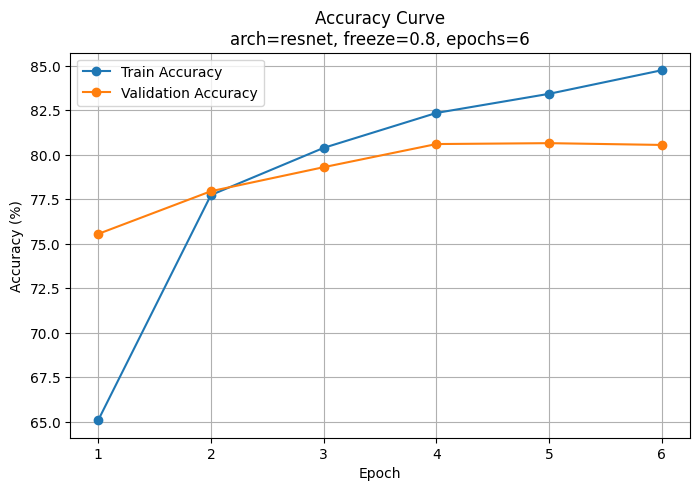

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
import wandb

# Setup for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def get_model(name, freeze_ratio, last_only=False):
    if name == 'resnet':
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)

    elif name == 'inception':
        weights = Inception_V3_Weights.DEFAULT
        model = models.inception_v3(weights=weights)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)

    if last_only:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        total = sum(1 for _ in model.children())
        freeze_layers = int(freeze_ratio * total)
        for idx, child in enumerate(model.children()):
            for param in child.parameters():
                param.requires_grad = idx >= freeze_layers

    return model


# Dataset loader
def prepare_data(data_path, augment=False):
    if augment:
        tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    else:
        tfms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    full_data = ImageFolder(data_path, transform=tfms)
    train_idx, val_idx = train_test_split(range(len(full_data)), test_size=0.2, random_state=42)
    train_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(train_idx))
    val_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(val_idx))
    return train_loader, val_loader

import matplotlib.pyplot as plt

def run_training(model, train_dl, val_dl, num_epochs, cfg):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_dl)
        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)

        wandb.log({"Train Loss": avg_loss, "Train Accuracy": train_acc})

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_acc = 100 * correct_val / total_val
        val_acc_list.append(val_acc)

        wandb.log({"Validation Accuracy": val_acc, "Epoch": epoch + 1})

        # Print accuracy
        print(f"Epoch {epoch + 1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    print("Training finished.")

    # Plot and save
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Accuracy", marker='o')
    plt.plot(range(1, num_epochs + 1), val_acc_list, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curve\narch={cfg.architecture}, freeze={cfg.freeze_ratio}, epochs={cfg.epochs}")
    plt.legend()
    plt.grid(True)
    
    filename = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}.png"
    plt.savefig(filename)
    print(f"Saved accuracy plot as {filename}")


# WandB Sweep setup
sweep_configuration = {
    'method': 'random',
    'metric': {'name': 'Validation Accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [20]},
        'freeze_ratio': {'values': [0.8]},
        'architecture': {'values': ['resnet']}  # You can add 'inception' here
    }
}

# Replace with your own API key
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")
sweep_id = wandb.sweep(sweep=sweep_configuration, project="A2_PartB_finetune_random")

# # Sweep run function
# def sweep_runner():
#     with wandb.init() as run:
#         cfg = wandb.config
#         wandb.run.name = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}"

#         model = get_model(cfg.architecture, cfg.freeze_ratio, last_only=False)
#         data_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"
#         train_dl, val_dl = prepare_data(data_dir, augment=False)

#         run_training(model, train_dl, val_dl, num_epochs=cfg.epochs)


def sweep_runner():
    with wandb.init() as run:
        cfg = wandb.config
        wandb.run.name = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}"

        model = get_model(cfg.architecture, cfg.freeze_ratio, last_only=False)
        data_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"
        train_dl, val_dl = prepare_data(data_dir, augment=False)

        # Pass cfg to run_training
        run_training(model, train_dl, val_dl, num_epochs=cfg.epochs, cfg=cfg)



# def sweep_runner():
#     with wandb.init() as run:
#         cfg = wandb.config
#         wandb.run.name = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}"

#         model = get_model(cfg.architecture, cfg.freeze_ratio, last_only=False)
#         train_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"
#         val_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/val"

#         train_dl, val_dl = prepare_data(train_dir, augment=False)
#         run_training(model, train_dl, val_dl, num_epochs=cfg.epochs, cfg=cfg)

#         # 🔽 Load test set from val directory and predict
#         test_loader, class_names = load_test_data(val_dir, batch_size=32)
#         predict_and_log_images(model, test_loader, class_names)




# Launch sweep
wandb.agent(sweep_id, function=sweep_runner, count=1)
wandb.finish()


In [1]:
def load_test_data(val_path, batch_size=32):
    tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    test_dataset = ImageFolder(val_path, transform=tfms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader, test_dataset.classes


import wandb
import torchvision
import numpy as np

def predict_and_log_images(model, test_loader, class_names):
    model.eval()
    logged_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                img = images[i].cpu()
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]

                caption = f"Pred: {pred_label} | Actual: {true_label}"
                logged_images.append(wandb.Image(img, caption=caption))

            # Limit to 30 images
            if len(logged_images) >= 30:
                break

    wandb.log({"Test Predictions": logged_images})
    print("Logged predictions to wandb.")


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
import wandb  # for logging and visualization

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get the pretrained model with some layers frozen
def get_model(name, freeze_ratio, last_only=False):
    # If architecture is ResNet
    if name == 'resnet':
        weights = ResNet50_Weights.DEFAULT  # Load default pretrained weights
        model = models.resnet50(weights=weights)  # Load pretrained ResNet50 model
        num_features = model.fc.in_features  # Get number of input features to final FC layer
        model.fc = nn.Linear(num_features, 10)  # Replace final FC layer for 10 classes

    # If architecture is Inception
    elif name == 'inception':
        weights = Inception_V3_Weights.DEFAULT
        model = models.inception_v3(weights=weights)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)  # Replace final FC layer for 10 classes

    # Option to freeze all layers except the final one
    if last_only:
        for param in model.parameters():
            param.requires_grad = False  # Freeze all layers
        for param in model.fc.parameters():
            param.requires_grad = True  # Unfreeze final FC layer only
    else:
        # Freeze only a certain ratio of layers from the beginning
        total = sum(1 for _ in model.children())  # Count total layers
        freeze_layers = int(freeze_ratio * total)  # Number of layers to freeze
        for idx, child in enumerate(model.children()):
            for param in child.parameters():
                param.requires_grad = idx >= freeze_layers  # Freeze first part, unfreeze the rest

    return model  # Return customized model


# Function to load and preprocess the dataset
def prepare_data(data_path, augment=False):
    # Apply data augmentation if specified
    if augment:
        tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    else:
        # Simple resizing and normalization for validation
        tfms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    # Load dataset from folders
    full_data = ImageFolder(data_path, transform=tfms)

    # Split indices for training and validation (80-20 split)
    train_idx, val_idx = train_test_split(range(len(full_data)), test_size=0.2, random_state=42)

    # Create data loaders
    train_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(train_idx))
    val_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(val_idx))
    return train_loader, val_loader

import matplotlib.pyplot as plt

# Function to train the model and validate it after each epoch
def run_training(model, train_dl, val_dl, num_epochs, cfg):
    model.to(device)  # Move model to GPU if available
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        # Iterate over training batches
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(imgs)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)

        avg_loss = total_loss / len(train_dl)
        train_acc = 100 * correct / total  # Training accuracy
        train_acc_list.append(train_acc)

        # Log training metrics to WandB
        wandb.log({"Train Loss": avg_loss, "Train Accuracy": train_acc})

        # Validation loop (no gradient updates)
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_acc = 100 * correct_val / total_val  # Validation accuracy
        val_acc_list.append(val_acc)

        # Log validation metrics to WandB
        wandb.log({"Validation Accuracy": val_acc, "Epoch": epoch + 1})

        # Print training progress
        print(f"Epoch {epoch + 1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    print("Training finished.")

    # Plot and save the accuracy graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Accuracy", marker='o')
    plt.plot(range(1, num_epochs + 1), val_acc_list, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curve\narch={cfg.architecture}, freeze={cfg.freeze_ratio}, epochs={cfg.epochs}")
    plt.legend()
    plt.grid(True)

    # Save the accuracy plot as an image
    filename = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}.png"
    plt.savefig(filename)
    print(f"Saved accuracy plot as {filename}")


# WandB sweep configuration for trying different hyperparameters automatically
sweep_configuration = {
    'method': 'random',  # Random search over parameter space
    'metric': {'name': 'Validation Accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [20]},  # Number of training epochs
        'freeze_ratio': {'values': [0.8]},  # How much of the model to freeze
        'architecture': {'values': ['resnet']}  # Architecture to use
    }
}

# Login to Weights & Biases using your API key
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")
# Initialize sweep in WandB with given configuration
sweep_id = wandb.sweep(sweep=sweep_configuration, project="A2_PartB_finetune_random")


# Function that runs for each sweep iteration
def sweep_runner():
    with wandb.init() as run:  # Start a new wandb run
        cfg = wandb.config  # Access configuration parameters
        wandb.run.name = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}"

        # Get the model based on config
        model = get_model(cfg.architecture, cfg.freeze_ratio, last_only=False)

        # Prepare training and validation data
        data_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"
        train_dl, val_dl = prepare_data(data_dir, augment=False)

        # Train the model and log results
        run_training(model, train_dl, val_dl, num_epochs=cfg.epochs, cfg=cfg)


# Start the sweep agent, run sweep_runner once
wandb.agent(sweep_id, function=sweep_runner, count=1)
# Finish WandB run
wandb.finish()
